<a href="https://colab.research.google.com/github/amnbot/Mais202/blob/main/MoodFaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Manga Faces Mood Classifier

Dataset: https://www.kaggle.com/datasets/mertkkl/manga-facial-expressions

References: 

1.   [ \[Pytorch\] - Manga Facial Expression Classificationt](https://www.kaggle.com/code/mertkkl/pytorch-manga-facial-expression-classification/)
2.   [POZZ (MAIS Hacks submission)](https://github.com/amnbot/POZZ/blob/master/jupyter/model.ipynb)


**To look at:**

https://stackoverflow.com/questions/61858768/why-is-the-accuracy-of-my-pretrained-resnet-152-model-so-low


In [50]:
# Imports

import torchvision
import torchvision.datasets as datasets # For importing dataset
import torchvision.models as models # For ResNet-50

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import numpy as np


In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Device to send data and model to

**From PyTorch [documentation](https://pytorch.org/hub/pytorch_vision_resnet/):**

"All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]."

In [53]:
# Image preprocessing
from PIL import Image
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # These values seem to be a sort of "convention" (found in docs and other projects)
])

In [54]:
# Load the dataset
dataset = datasets.ImageFolder('/content/drive/MyDrive/MAIS 202/Project/Tests/manga-faces', transform=preprocess)
print(len(dataset))
dataset_size = len(dataset)

455


In [55]:
# Split the dataset into training and testing dataset
# Using a 80 % of data for training and 20 % for training
train_size = int(0.8 * dataset_size)
num_display_images = 5
test_size = dataset_size - train_size - num_display_images
train_ds, test_ds, display_imgs = data.random_split(dataset, [train_size, test_size, num_display_images])

In [56]:
train_loader = data.DataLoader(train_ds, shuffle=True, batch_size=15)
test_loader = data.DataLoader(test_ds, shuffle=True, batch_size=10)
display_loader = data.DataLoader(display_imgs, shuffle=True, batch_size=num_display_images)

[Visualizing a grid of images](https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#sphx-glr-auto-examples-plot-visualization-utils-py)

['angry', 'sad', 'pleased', 'happy', 'embarrassed']


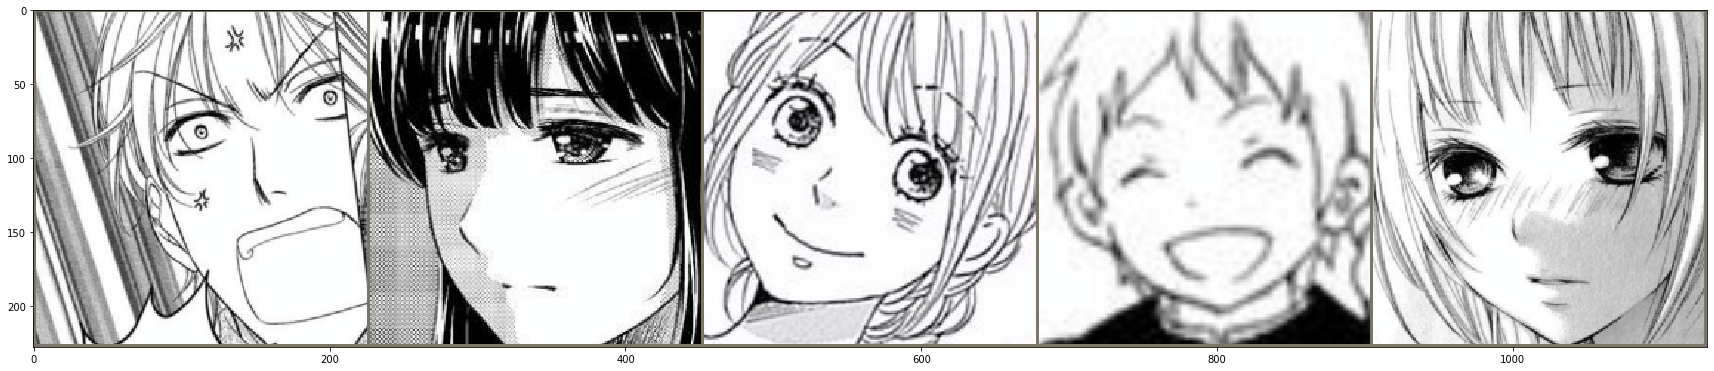

In [57]:
# Display the images (for preprocessing)
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.transforms.functional as Func

def show(imgs):
  ax = plt.subplots(figsize = (30, 90))
  inp = imgs.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp, interpolation='nearest')

inputs, labels = next(iter(display_loader))
idx_to_class = {v: k for k, v in display_loader.dataset.dataset.class_to_idx.items()}
display_moods = []
for label in labels:
  display_moods.append(idx_to_class[int(label)])
print(display_moods)
grid = make_grid(inputs)
show(grid)

**From PyTorch [documentation](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)**

"By default, when we load a pretrained model all of the parameters have .requires_grad=True, which is fine if we are training from scratch or finetuning. However, if we are feature extracting and only want to compute gradients for the newly initialized layer then we want all of the other parameters to not require gradients. This will make more sense later."

In [59]:
criter = nn.CrossEntropyLoss()
model = models.resnet50(pretrained=True)

# Replace the last fully-connected (fc) layer since we only have 7 classes
for param in model.parameters():
    param.requires_grad  = False

in_feats = model.fc.in_features
num_classes = 7
model.fc = nn.Linear(in_feats, num_classes)
model = model.to(device) # Move model to device

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

In [60]:
# Training function (training done twice, once for the last layer, and another time for the entire model)

def train_model(model, epoch, loss_lst):
  model.train()
  running_loss = 0

  for batch, (inputs, labels) in enumerate(train_loader):
    inputs, labels = inputs.to(device), labels.to(device) # Move data to device
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criter(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()*inputs.size(0)

    if (batch % 5 == 0):
      print(f'Epoch: {epoch} \t Loss: {loss}')
  
  running_loss /= len(train_loader.dataset)
  loss_lst.append(running_loss)
  print(f'Average loss: {running_loss}')

In [61]:
# Train last layer

num_epochs_last_layer = 5
print('Training last layer...')
train_loss = []
for epoch in range(1, num_epochs_last_layer + 1):
  train_model(model, epoch, train_loss)

Training last layer...
Epoch: 1 	 Loss: 1.9437073469161987
Epoch: 1 	 Loss: 1.8874748945236206
Epoch: 1 	 Loss: 1.9173128604888916
Epoch: 1 	 Loss: 2.057199001312256
Epoch: 1 	 Loss: 1.6293532848358154
Average loss: 1.905192148226958
Epoch: 2 	 Loss: 1.649436593055725
Epoch: 2 	 Loss: 1.3726824522018433
Epoch: 2 	 Loss: 1.7310763597488403
Epoch: 2 	 Loss: 1.549869179725647
Epoch: 2 	 Loss: 1.6793285608291626
Average loss: 1.589662947825023
Epoch: 3 	 Loss: 1.3864713907241821
Epoch: 3 	 Loss: 1.4176437854766846
Epoch: 3 	 Loss: 1.176155924797058
Epoch: 3 	 Loss: 1.653791904449463
Epoch: 3 	 Loss: 1.1416047811508179
Average loss: 1.4254987855533978
Epoch: 4 	 Loss: 1.110777735710144
Epoch: 4 	 Loss: 1.2422611713409424
Epoch: 4 	 Loss: 1.2973507642745972
Epoch: 4 	 Loss: 1.131372332572937
Epoch: 4 	 Loss: 1.2948594093322754
Average loss: 1.312216491162122
Epoch: 5 	 Loss: 1.1886268854141235
Epoch: 5 	 Loss: 1.4330556392669678
Epoch: 5 	 Loss: 1.179137110710144
Epoch: 5 	 Loss: 1.177944421

[1.905192148226958, 1.589662947825023, 1.4254987855533978, 1.312216491162122, 1.2148228698706889]


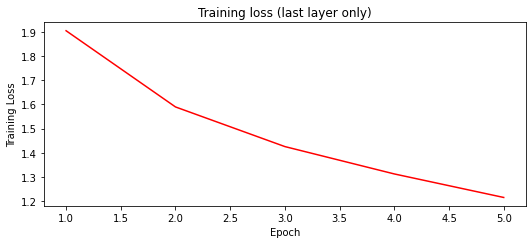

In [62]:
print(train_loss)

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title("Training loss (last layer only)")
plt.plot(range(1, len(train_loss) + 1), train_loss, color="red")
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.show()

From [docs](https://pytorch.org/docs/stable/generated/torch.argmax.html):



```
>>> a = torch.randn(4, 4)
>>> a
tensor([[ 1.3398,  0.2663, -0.2686,  0.2450],
        [-0.7401, -0.8805, -0.3402, -1.1936],
        [ 0.4907, -1.3948, -1.0691, -0.3132],
        [-1.6092,  0.5419, -0.2993,  0.3195]])
>>> torch.argmax(a, dim=1)
tensor([ 0,  2,  0,  1])
```



In [63]:
# Testing function

def test_model(model, loader, accuracy):
  total = 0
  correct = 0

  model.eval()
  with torch.no_grad():
    
    for batch, (inputs, labels) in enumerate(loader):
      inputs, labels = inputs.to(device), labels.to(device) # Move data to device

      outputs = model(inputs)
      # Use dim=1 to keep an array of the indices of the max values for each output
      pred = outputs.argmax(dim = 1, keepdim = False)
      res = torch.eq(pred, labels)
      for r in res:
        total += 1
        if r == True:
          correct += 1
      accuracy.append(correct / total)
      if (batch % 5 == 0):
        print(f'Accuracy: {correct} / {total} ({round((correct / total), 2)} %)')

In [64]:
# Training accuracy for last layer
training_accuracy = []
test_model(model, train_loader, training_accuracy)

Accuracy: 11 / 15 (0.73 %)
Accuracy: 62 / 90 (0.69 %)
Accuracy: 116 / 165 (0.7 %)
Accuracy: 171 / 240 (0.71 %)
Accuracy: 227 / 315 (0.72 %)


In [66]:
# Testing accuracy for last layer
testing_accuracy = []
test_model(model, test_loader, testing_accuracy)

Accuracy: 4 / 10 (0.4 %)
Accuracy: 27 / 60 (0.45 %)


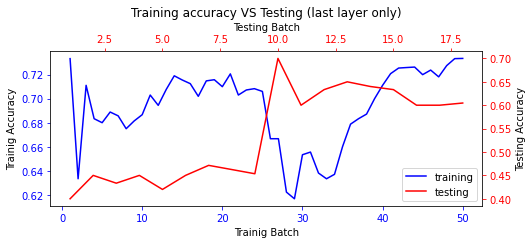

In [104]:
fig = plt.figure()
ax = fig.add_subplot(111, label="training")
ax2 = fig.add_subplot(111, label="testing", frame_on=False)
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title("Training accuracy VS Testing (last layer only)")

ax.plot(range(1, len(training_accuracy) + 1), training_accuracy, color="blue", label="training")
ax.set_xlabel("Trainig Batch")
ax.set_ylabel("Trainig Accuracy")
ax.tick_params(axis='x', colors="blue")
ax.tick_params(axis='y', colors="blue")

ax2.plot(range(1, len(testing_accuracy) + 1), testing_accuracy, color="red", label="testing")
ax2.set_xlabel("Testing Batch")
ax2.set_ylabel("Testing Accuracy")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="red")
ax2.tick_params(axis='y', colors="red")

handles, labels = [(a + b) for a, b in zip(ax.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
plt.legend(handles, labels, loc="lower right")
plt.show()

In [68]:
# Set requires_grad = True for the layer
for param in model.parameters():
  param.requires_grad = True

# Train entire model
num_epochs_entire_model = 5
model_train_loss = []
print('Training entire model...')
for epoch in range(1, num_epochs_entire_model + 1):
  train_model(model, epoch, model_train_loss)

Training entire model...
Epoch: 1 	 Loss: 1.3481420278549194
Epoch: 1 	 Loss: 2.34143328666687
Epoch: 1 	 Loss: 1.9346543550491333
Epoch: 1 	 Loss: 1.9253852367401123
Epoch: 1 	 Loss: 1.204076886177063
Average loss: 1.7537975923700646
Epoch: 2 	 Loss: 1.4581222534179688
Epoch: 2 	 Loss: 1.0624254941940308
Epoch: 2 	 Loss: 1.0301228761672974
Epoch: 2 	 Loss: 1.431697130203247
Epoch: 2 	 Loss: 1.1765788793563843
Average loss: 1.2672974373940582
Epoch: 3 	 Loss: 1.4411457777023315
Epoch: 3 	 Loss: 1.1340763568878174
Epoch: 3 	 Loss: 1.250304102897644
Epoch: 3 	 Loss: 0.9192873239517212
Epoch: 3 	 Loss: 0.9836424589157104
Average loss: 1.1801053203724243
Epoch: 4 	 Loss: 0.7616439461708069
Epoch: 4 	 Loss: 0.8942320346832275
Epoch: 4 	 Loss: 0.739617109298706
Epoch: 4 	 Loss: 0.7546291947364807
Epoch: 4 	 Loss: 0.9622090458869934
Average loss: 1.0095001753051203
Epoch: 5 	 Loss: 0.5197993516921997
Epoch: 5 	 Loss: 0.9690229892730713
Epoch: 5 	 Loss: 0.5754930973052979
Epoch: 5 	 Loss: 0.60

[1.7537975923700646, 1.2672974373940582, 1.1801053203724243, 1.0095001753051203, 0.7294024405898628]


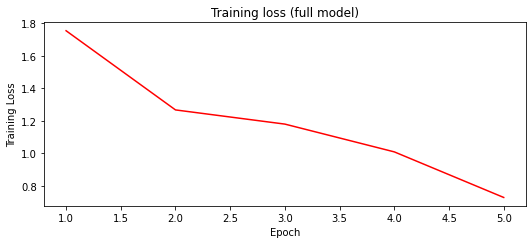

In [108]:
print(model_train_loss)

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title("Training loss (full model)")
plt.plot(range(1, len(model_train_loss) + 1), model_train_loss, color="red")
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.show()

In [72]:
# Training accuracy for entire model
model_training_accuracy = []
test_model(model, train_loader, model_training_accuracy)

Accuracy: 12 / 15 (0.8 %)
Accuracy: 61 / 90 (0.68 %)
Accuracy: 124 / 165 (0.75 %)
Accuracy: 176 / 240 (0.73 %)
Accuracy: 234 / 315 (0.74 %)


In [76]:
# Testing accuracy for entire model
model_testing_accuracy = []
test_model(model, test_loader, model_testing_accuracy)

Accuracy: 5 / 10 (0.5 %)
Accuracy: 35 / 60 (0.58 %)


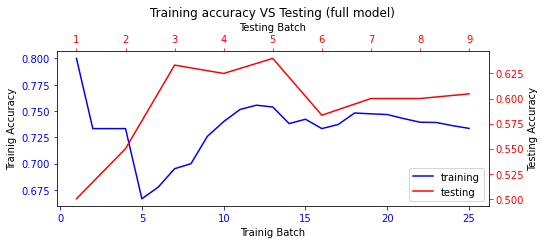

In [106]:
fig = plt.figure()
ax = fig.add_subplot(111, label="training")
ax2 = fig.add_subplot(111, label="testing", frame_on=False)
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title("Training accuracy VS Testing (full model)")

ax.plot(range(1, len(model_training_accuracy) + 1), model_training_accuracy, color="blue", label="training")
ax.set_xlabel("Trainig Batch")
ax.set_ylabel("Trainig Accuracy")
ax.tick_params(axis='x', colors="blue")
ax.tick_params(axis='y', colors="blue")

ax2.plot(range(1, len(model_testing_accuracy) + 1), model_testing_accuracy, color="red", label="testing")
ax2.set_xlabel("Testing Batch")
ax2.set_ylabel("Testing Accuracy")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="red")
ax2.tick_params(axis='y', colors="red")

handles, labels = [(a + b) for a, b in zip(ax.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
plt.legend(handles, labels, loc="lower right")
plt.show()

In [78]:
"""
Show a grid of the images, the prediction VS the expected answer
"""

'\nShow a grid of the images, the prediction VS the expected answer\n'

In [107]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted_1.pt') # Save